In [387]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [388]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("phileinsophos/predict-loan-amount-data")

# print("Path to dataset files:", path)
path = "/kaggle/input/predict-loan-amount-data"

In [389]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso

train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

In [390]:
len(train)

30000

In [391]:
train.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [392]:
train.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


In [393]:
unnecessary_columns = ['Customer ID', 'Name', 'Property ID']
train.drop(columns=unnecessary_columns, inplace=True)

In [394]:
# Check for missing values
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing_values[missing_values > 0])

# Drop rows with too many missing values or fill them appropriately
train.fillna({
    'Credit Score': train['Credit Score'].median(),
    'Property Age': train['Property Age'].median(),
    'Income (USD)': train['Income (USD)'].median(),
    'Loan Amount Request (USD)': train['Loan Amount Request (USD)'].median(),
    'Current Loan Expenses (USD)': 0,
    'No. of Defaults': 0,
    'Dependents': 0,
}, inplace=True)

unused = train[train['Loan Sanction Amount (USD)'].isna() | train['Loan Sanction Amount (USD)'] <= 0]
print(len(unused))

train = train[~train['Loan Sanction Amount (USD)'].isna()]
train = train[train['Loan Sanction Amount (USD)'] > 0]

# For categorical: fill with mode
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].fillna(train[col].mode()[0])

Missing values:
 Type of Employment             7270
Property Age                   4850
Income (USD)                   4576
Dependents                     2493
Credit Score                   1703
Income Stability               1683
Has Active Credit Card         1566
Property Location               356
Loan Sanction Amount (USD)      340
Current Loan Expenses (USD)     172
Gender                           53
dtype: int64
7865


/tmp/ipython-input-394-3863866817.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].fillna(train[col].mode()[0])


In [395]:
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Series([], dtype: int64)


In [396]:
len(train)

21457

In [397]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include='object').columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

In [398]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [
    'Age', 'Current Loan Expenses (USD)', 'Property Price',
    'No. of Defaults', 'Credit Score', 'Income (USD)',
    'Loan Amount Request (USD)', 'Property Age'
]

scaler = StandardScaler()
train[features_to_scale] = scaler.fit_transform(train[features_to_scale])

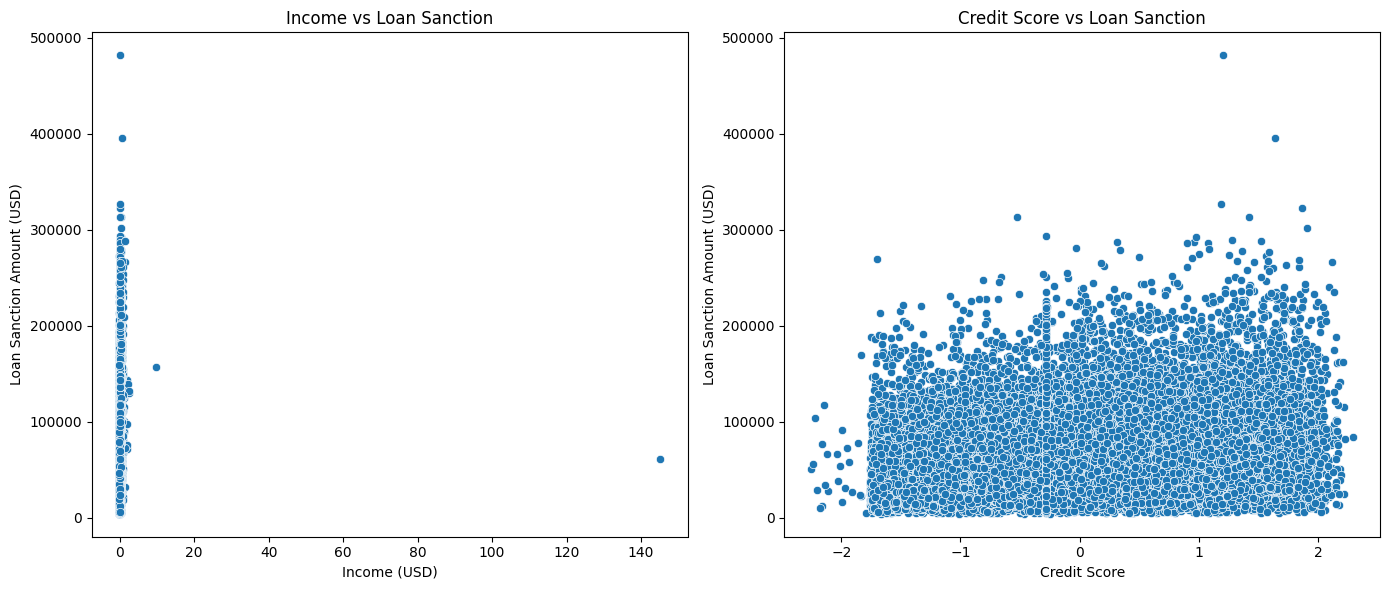

In [399]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=train, x='Income (USD)', y='Loan Sanction Amount (USD)', ax=axs[0])
sns.scatterplot(data=train, x='Credit Score', y='Loan Sanction Amount (USD)', ax=axs[1])
axs[0].set_title("Income vs Loan Sanction")
axs[1].set_title("Credit Score vs Loan Sanction")
plt.tight_layout()
plt.show()

In [400]:
train = train[train['Income (USD)'] < 4]

In [401]:
print(len(train))
train.head()

21455


,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,0,0.962914,-0.055270,1,6,14,1,-0.307364,-0.644601,0,...,3.0,0.865356,-0.490120,0,-0.054941,4,0,1,-0.163413,54607.18
1,1,-0.517489,0.191760,1,6,8,1,-0.734569,0.367181,0,...,1.0,0.387511,-0.490120,2,0.192111,2,0,1,-0.843842,37469.98
2,0,1.518065,-0.132561,0,3,8,1,-0.755038,-0.919184,0,...,1.0,1.255499,-0.490120,2,-0.132239,2,2,0,-0.659488,36474.43
3,0,1.518065,-0.031597,0,3,8,0,-0.188139,-0.416371,0,...,2.0,1.248094,2.040318,2,-0.031200,2,1,1,-0.147661,56040.54
4,0,-0.579172,0.000496,1,6,6,1,0.367839,0.349704,0,...,0.0,-0.185937,2.040318,0,0.000830,4,1,1,0.762395,74008.28


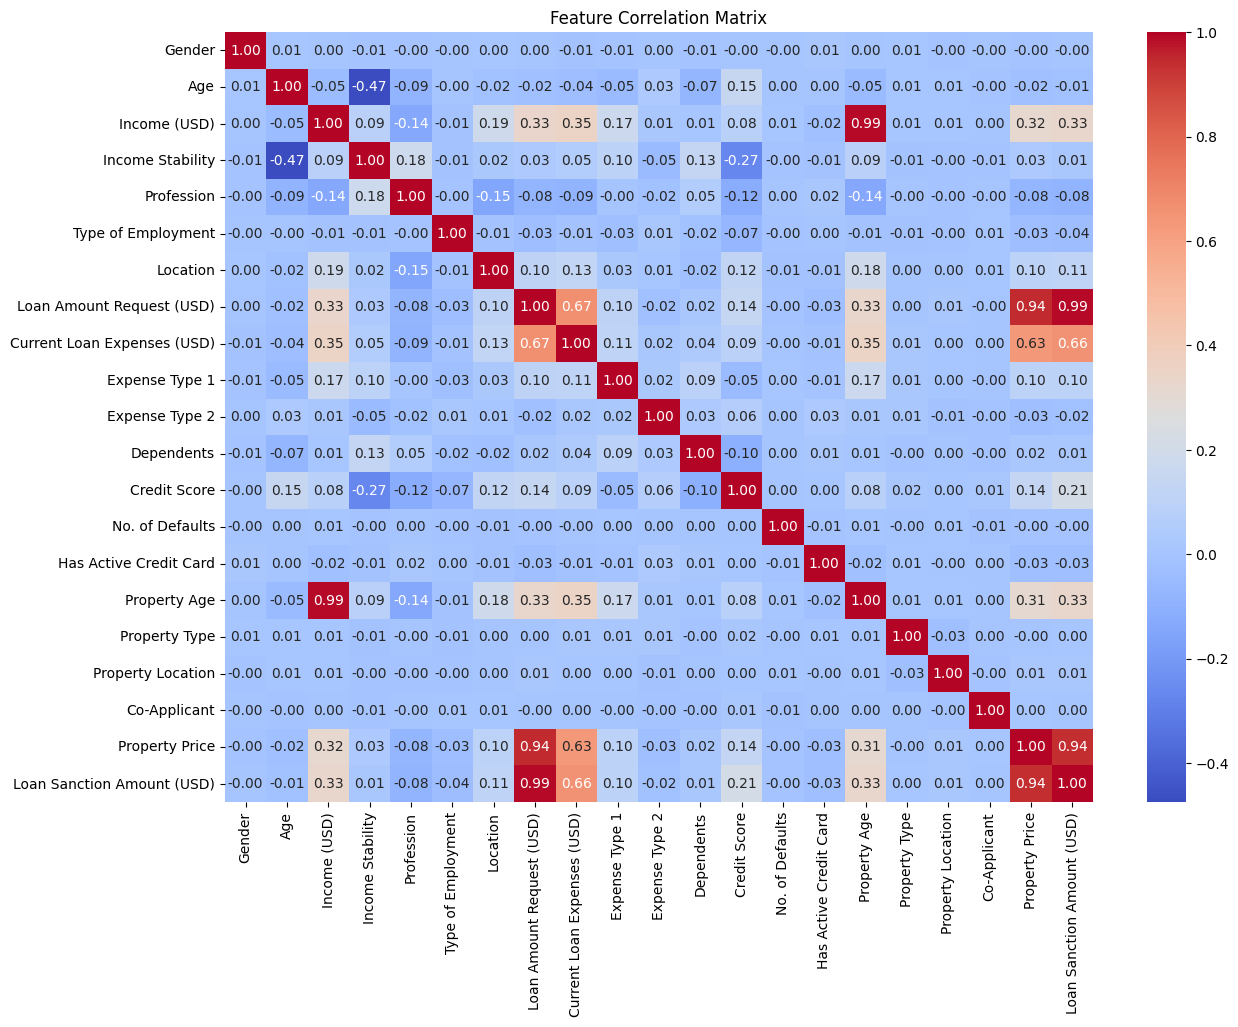

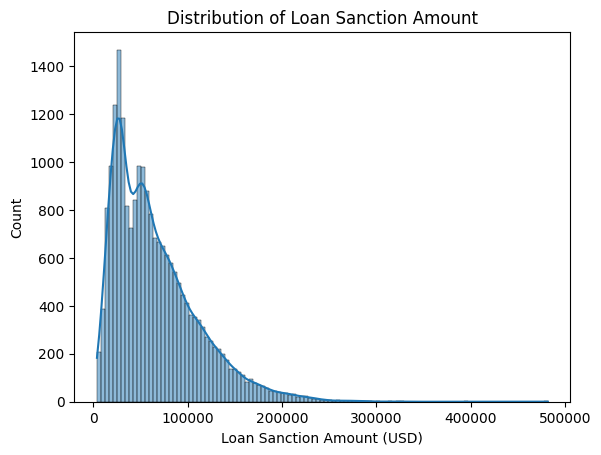

In [402]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(train.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Target variable distribution
sns.histplot(train['Loan Sanction Amount (USD)'], kde=True)
plt.title("Distribution of Loan Sanction Amount")
plt.show()

In [403]:
X = train.drop(columns=['Loan Sanction Amount (USD)'])
y = train['Loan Sanction Amount (USD)']

In [404]:
# Bin target variable for stratified sampling (5 bins for 5 folds)
y_binned = pd.qcut(y, q=5, labels=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists for test metrics
mae_scores_test = []
mse_scores_test = []
rmse_scores_test = []
r2_scores_test = []
adj_r2_scores_test = []

# Lists for train metrics
mae_scores_train = []
mse_scores_train = []
rmse_scores_train = []
r2_scores_train = []
adj_r2_scores_train = []

fold = 1
results = []

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

saved = False

for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    if not saved:
        X_train = X_train_fold
        y_train = y_train_fold
        X_val = X_val_fold
        y_val = y_val_fold
        saved = True

    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)

    # Predictions
    y_pred_val = model.predict(X_val_fold)
    y_pred_train = model.predict(X_train_fold)

    # --- Test Metrics ---
    mae_test = mean_absolute_error(y_val_fold, y_pred_val)
    mse_test = mean_squared_error(y_val_fold, y_pred_val)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_val_fold, y_pred_val)
    adj_r2_test = adjusted_r2(r2_test, len(y_val_fold), X_val_fold.shape[1])

    # --- Train Metrics ---
    mae_train = mean_absolute_error(y_train_fold, y_pred_train)
    mse_train = mean_squared_error(y_train_fold, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train_fold, y_pred_train)
    adj_r2_train = adjusted_r2(r2_train, len(y_train_fold), X_train_fold.shape[1])

    # Store test metrics
    mae_scores_test.append(mae_test)
    mse_scores_test.append(mse_test)
    rmse_scores_test.append(rmse_test)
    r2_scores_test.append(r2_test)
    adj_r2_scores_test.append(adj_r2_test)

    # Store train metrics
    mae_scores_train.append(mae_train)
    mse_scores_train.append(mse_train)
    rmse_scores_train.append(rmse_train)
    r2_scores_train.append(r2_train)
    adj_r2_scores_train.append(adj_r2_train)

    # Store fold results
    results.append([
        f"Fold {fold}",
        mae_train, mae_test,
        mse_train, mse_test,
        rmse_train, rmse_test,
        r2_train, r2_test,
        adj_r2_train, adj_r2_test
    ])
    fold += 1

# Add average row
results.append([
    "Average",
    np.mean(mae_scores_train), np.mean(mae_scores_test),
    np.mean(mse_scores_train), np.mean(mse_scores_test),
    np.mean(rmse_scores_train), np.mean(rmse_scores_test),
    np.mean(r2_scores_train), np.mean(r2_scores_test),
    np.mean(adj_r2_scores_train), np.mean(adj_r2_scores_test)
])

# Display as DataFrame
cv_results_df = pd.DataFrame(
    results,
    columns=[
        "Fold",
        "MAE (Train)", "MAE (Test)",
        "MSE (Train)", "MSE (Test)",
        "RMSE (Train)", "RMSE (Test)",
        "R² (Train)", "R² (Test)",
        "Adj R² (Train)", "Adj R² (Test)"
    ]
)

print(cv_results_df)

      Fold  MAE (Train)   MAE (Test)   MSE (Train)    MSE (Test)  \
0   Fold 1  3647.401872  3599.761907  2.813528e+07  2.797170e+07   
1   Fold 2  3644.762993  3615.363921  2.807816e+07  2.820013e+07   
2   Fold 3  3644.643969  3617.708681  2.843115e+07  2.677894e+07   
3   Fold 4  3624.183912  3662.087210  2.802195e+07  2.842962e+07   
4   Fold 5  3618.350259  3705.271350  2.776791e+07  2.945018e+07   
5  Average  3635.868601  3640.038614  2.808689e+07  2.816611e+07   

   RMSE (Train)  RMSE (Test)  R² (Train)  R² (Test)  Adj R² (Train)  \
0   5304.269977  5288.827940    0.985877   0.986626        0.985860   
1   5298.882503  5310.379864    0.986075   0.985860        0.986059   
2   5332.087205  5174.836838    0.985967   0.986309        0.985950   
3   5293.576528  5331.942925    0.986068   0.985887        0.986052   
4   5269.526674  5426.801664    0.986213   0.985301        0.986197   
5   5299.668577  5306.557846    0.986040   0.985997        0.986024   

   Adj R² (Test)  
0     

In [405]:
# Bin target variable for stratified sampling (5 bins for 5 folds)
y_binned = pd.qcut(y, q=5, labels=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

fold = 1
results = []

def adjusted_r2(r2, n, k):
    """Calculates adjusted R² score."""
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

saved = False

# Perform Stratified K-Fold Cross-Validation
for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    if not saved:
        X_train = X_train_fold
        y_train = y_train_fold
        X_val = X_val_fold
        y_val = y_val_fold
        saved = True

    model = Ridge(alpha=1000)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)

    # Calculate performance metrics
    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_fold, y_pred)

    # Calculate Adjusted R²
    n = X_val_fold.shape[0]  # Number of samples in validation set
    k = X_val_fold.shape[1]  # Number of features
    adj_r2 = adjusted_r2(r2, n, k)

    # Store the results for each fold
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    results.append([f"Fold {fold}", mae, mse, rmse, r2, adj_r2])
    fold += 1

# Add average row
results.append(["Average", np.mean(mae_scores), np.mean(mse_scores),
                np.mean(rmse_scores), np.mean(r2_scores), np.mean(adj_r2_scores)])

# Convert to DataFrame for display
cv_results_df = pd.DataFrame(results, columns=["Fold", "MAE", "MSE", "RMSE", "R² Score", "Adjusted R² Score"])
print(cv_results_df)

      Fold          MAE           MSE         RMSE  R² Score  \
0   Fold 1  4411.728183  4.383576e+07  6620.857823  0.979040   
1   Fold 2  4424.029974  4.390208e+07  6625.864712  0.977986   
2   Fold 3  4546.914805  4.578637e+07  6766.562492  0.976592   
3   Fold 4  4450.816343  4.554954e+07  6749.039872  0.977389   
4   Fold 5  4462.647916  4.414179e+07  6643.928460  0.977969   
5  Average  4459.227444  4.464311e+07  6681.250672  0.977795   

   Adjusted R² Score  
0           0.978942  
1           0.977883  
2           0.976482  
3           0.977283  
4           0.977866  
5           0.977691  


In [406]:
# Bin target variable for stratified sampling (5 bins for 5 folds)
y_binned = pd.qcut(y, q=5, labels=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

fold = 1
results = []

def adjusted_r2(r2, n, k):
    """Calculates adjusted R² score."""
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

saved = False

# Perform Stratified K-Fold Cross-Validation
for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    if not saved:
        X_train = X_train_fold
        y_train = y_train_fold
        X_val = X_val_fold
        y_val = y_val_fold
        saved = True

    model = Lasso(alpha=100, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)

    # Calculate performance metrics
    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_fold, y_pred)

    # Calculate Adjusted R²
    n = X_val_fold.shape[0]  # Number of samples in validation set
    k = X_val_fold.shape[1]  # Number of features
    adj_r2 = adjusted_r2(r2, n, k)

    # Store the results for each fold
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    results.append([f"Fold {fold}", mae, mse, rmse, r2, adj_r2])
    fold += 1

# Add average row
results.append(["Average", np.mean(mae_scores), np.mean(mse_scores),
                np.mean(rmse_scores), np.mean(r2_scores), np.mean(adj_r2_scores)])

# Convert to DataFrame for display
cv_results_df = pd.DataFrame(results, columns=["Fold", "MAE", "MSE", "RMSE", "R² Score", "Adjusted R² Score"])
print(cv_results_df)

      Fold          MAE           MSE         RMSE  R² Score  \
0   Fold 1  3579.903348  2.799154e+07  5290.702960  0.986616   
1   Fold 2  3594.835461  2.819211e+07  5309.624612  0.985864   
2   Fold 3  3596.358311  2.678876e+07  5175.785575  0.986304   
3   Fold 4  3640.981504  2.844975e+07  5333.830562  0.985877   
4   Fold 5  3686.138595  2.948840e+07  5430.322687  0.985282   
5  Average  3619.643444  2.818211e+07  5308.053279  0.985989   

   Adjusted R² Score  
0           0.986553  
1           0.985797  
2           0.986240  
3           0.985811  
4           0.985213  
5           0.985923  


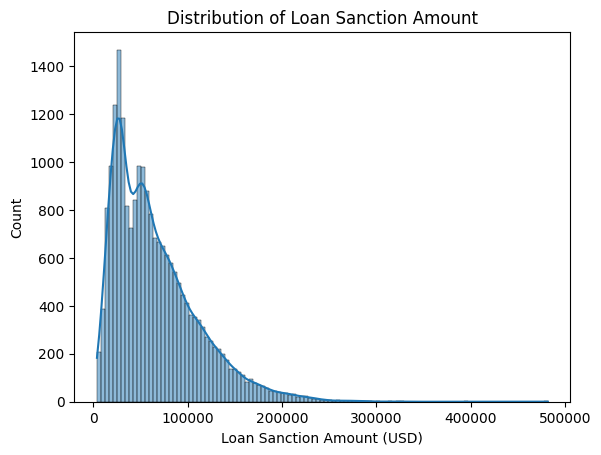

In [407]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogram / Distribution Plot
sns.histplot(train['Loan Sanction Amount (USD)'], kde=True)
plt.title("Distribution of Loan Sanction Amount")
plt.show()

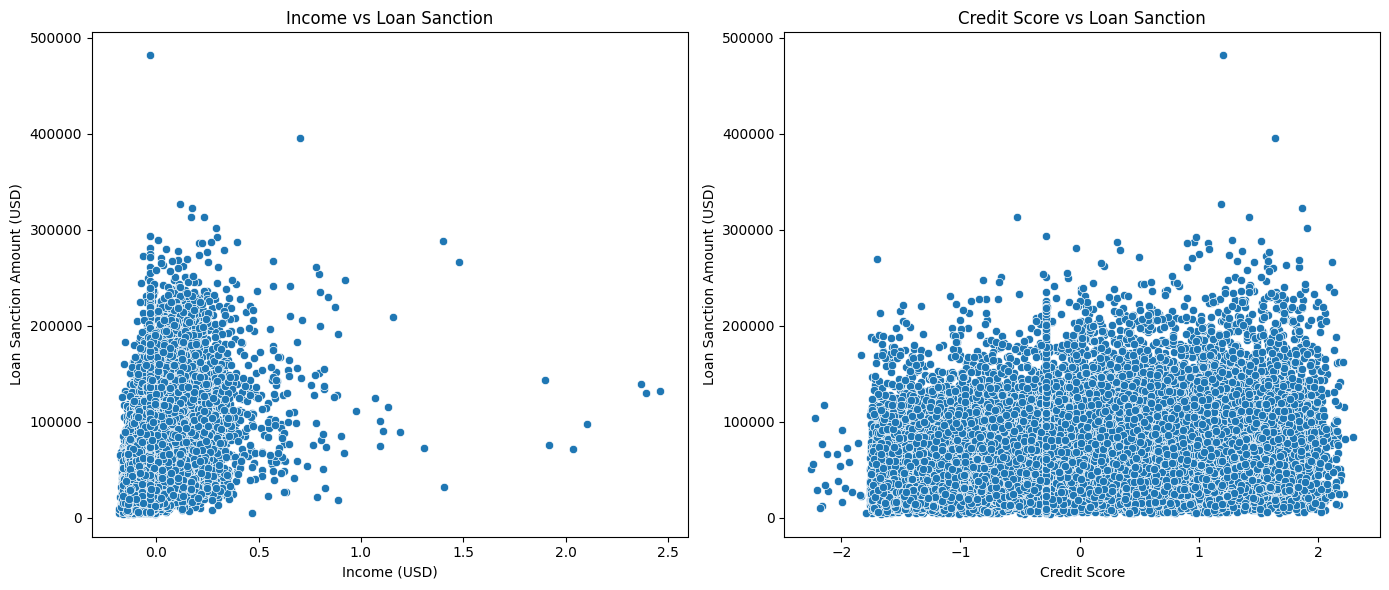

In [408]:
# 2. Scatter Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=train, x='Income (USD)', y='Loan Sanction Amount (USD)', ax=axs[0])
sns.scatterplot(data=train, x='Credit Score', y='Loan Sanction Amount (USD)', ax=axs[1])
axs[0].set_title("Income vs Loan Sanction")
axs[1].set_title("Credit Score vs Loan Sanction")
plt.tight_layout()
plt.show()

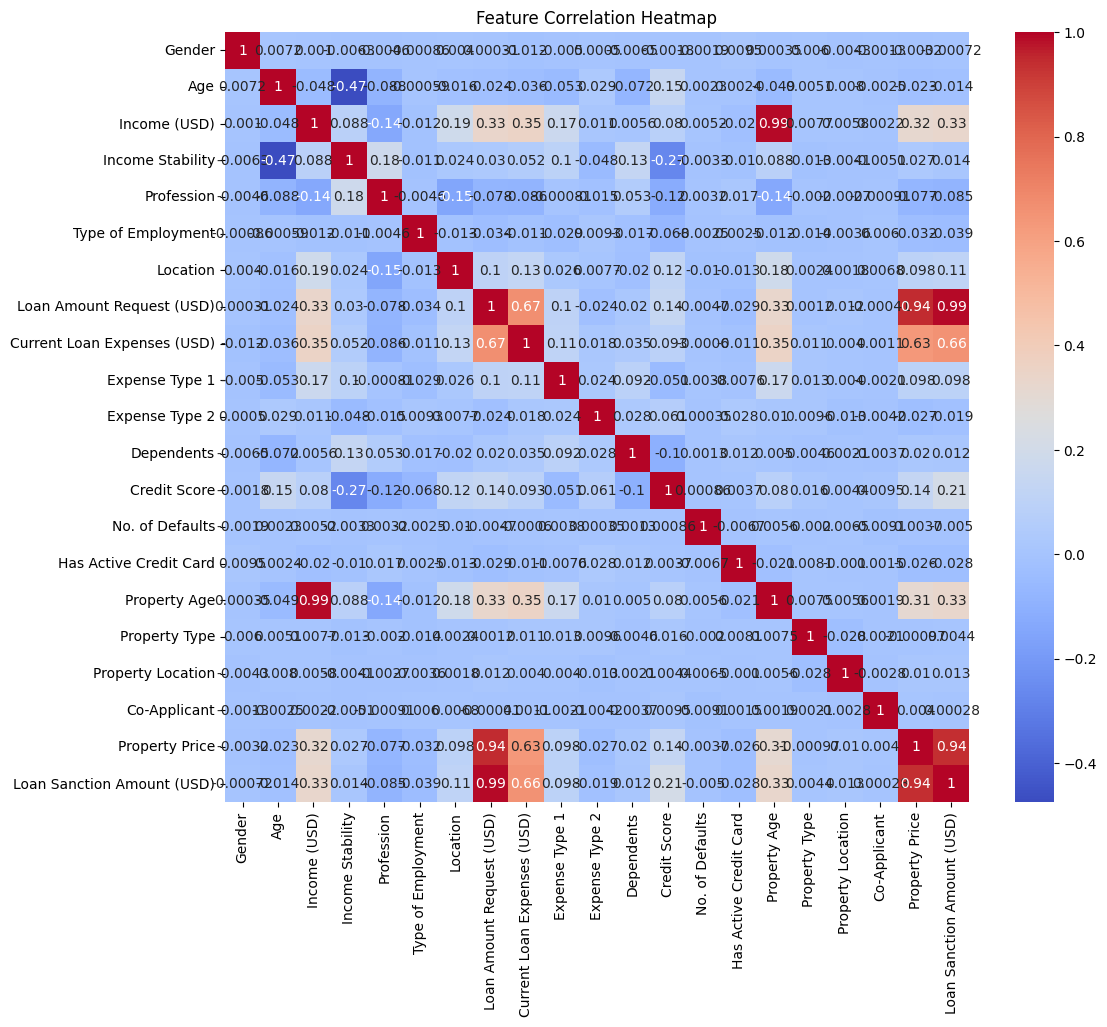

In [409]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

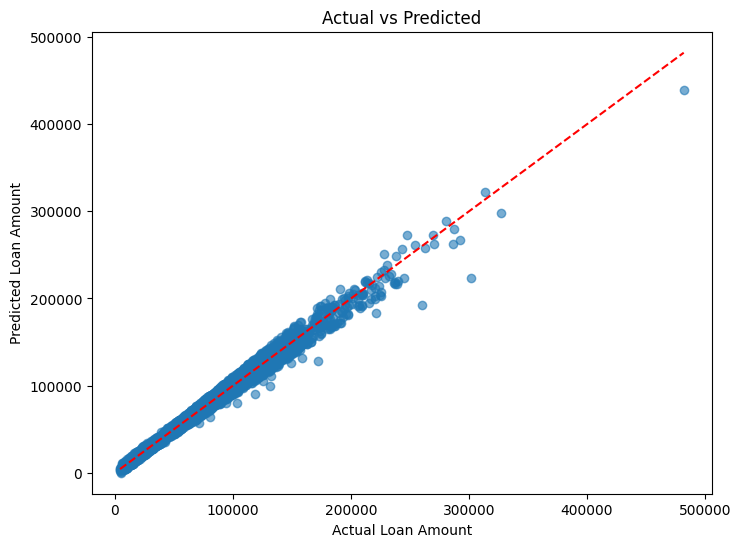

In [410]:
# 4. Actual vs Predicted
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted")
plt.show()

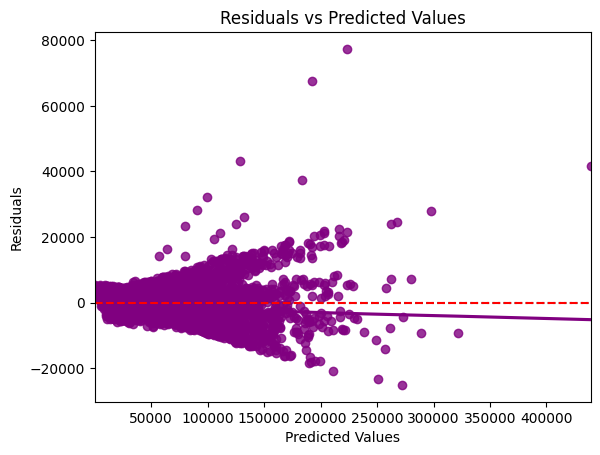

In [411]:
# 5. Residual Plot
residuals = y_val - y_pred
sns.residplot(x=y_pred, y=residuals, lowess=True, color="purple")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.axhline(0, color='red', linestyle='--')
plt.show()

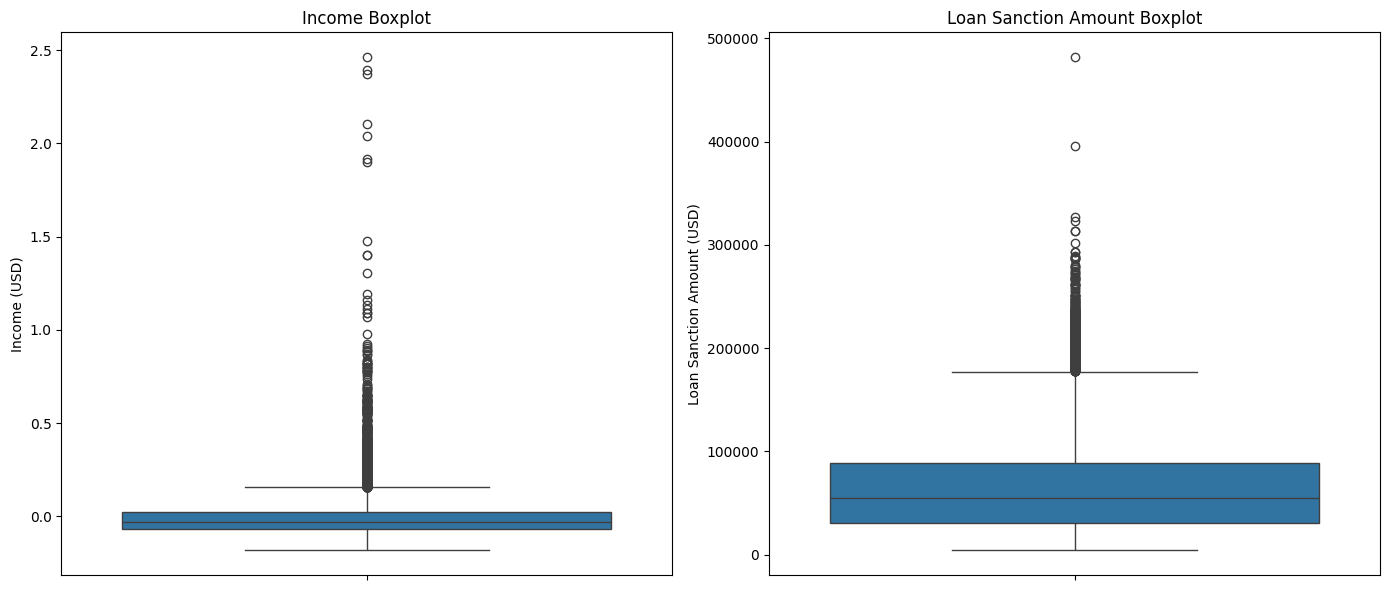

In [412]:
# 6. Boxplots (e.g., for income and loan)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(y=train['Income (USD)'], ax=axs[0])
sns.boxplot(y=train['Loan Sanction Amount (USD)'], ax=axs[1])
axs[0].set_title("Income Boxplot")
axs[1].set_title("Loan Sanction Amount Boxplot")
plt.tight_layout()
plt.show()

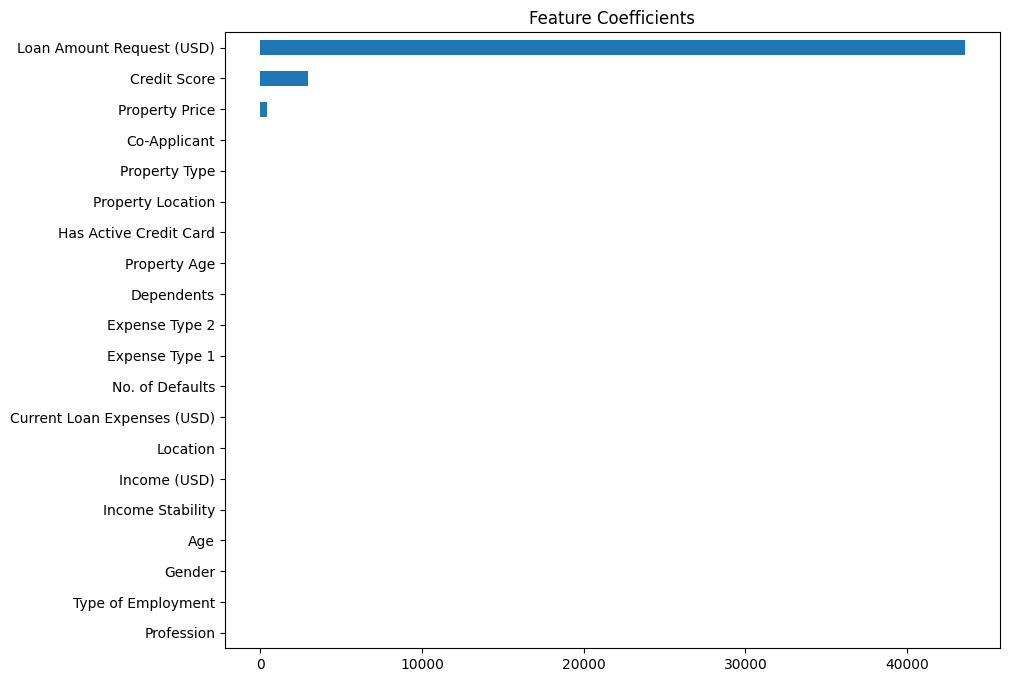

In [413]:
# 7. Bar Plot of Feature Coefficients
coeffs = pd.Series(model.coef_, index=X.columns)
coeffs.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Coefficients")
plt.show()

In [414]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

train = pd.concat([train, test])

# Drop unnecessary columns
unnecessary_columns = ['Customer ID', 'Name', 'Property ID']
train.drop(columns=unnecessary_columns, inplace=True)

# Fill missing values
train.fillna({
    'Credit Score': train['Credit Score'].median(),
    'Property Age': train['Property Age'].median(),
    'Income (USD)': train['Income (USD)'].median(),
    'Loan Amount Request (USD)': train['Loan Amount Request (USD)'].median(),
    'Current Loan Expenses (USD)': 0,
    'No. of Defaults': 0,
    'Dependents': 0,
}, inplace=True)

train = train[~train['Loan Sanction Amount (USD)'].isna()]

# Fill categorical missing with mode
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].fillna(train[col].mode()[0])

# Label Encoding categorical features
categorical_cols = train.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Features to scale
features_to_scale = [
    'Age', 'Income (USD)', 'Loan Amount Request (USD)',
    'Current Loan Expenses (USD)', 'Property Age', 'Property Price',
    'Credit Score', 'No. of Defaults'
]

scaler = StandardScaler()
train[features_to_scale] = scaler.fit_transform(train[features_to_scale])

# Feature engineering
train['Debt_to_Income'] = train['Current Loan Expenses (USD)'] / (train['Income (USD)'] + 1e-5)

# Prepare feature matrix X and target vector y
X = train.drop(columns=['Loan Sanction Amount (USD)'])
y = train['Loan Sanction Amount (USD)']

# Add intercept term (column of ones)
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.hstack((intercept, X))

# Normal Equation to compute weights
def normal_equation(X, y):
    # theta = (X^T X)^-1 X^T y
    X_transpose = X.T
    theta = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)
    return theta

# Prediction function
def predict(X, theta):
    return X.dot(theta)

# Metrics functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Bin y for stratified splits (5 bins)
y_binned = pd.qcut(y, q=5, labels=False)

# Using StratifiedKFold only for indices splitting (allowed here)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
adj_r2_scores = []

fold = 1
results = []

for train_idx, val_idx in skf.split(X, y_binned):
    X_train_fold = X.iloc[train_idx].values
    y_train_fold = y.iloc[train_idx].values
    X_val_fold = X.iloc[val_idx].values
    y_val_fold = y.iloc[val_idx].values

    # Add intercept term
    X_train_intercept = add_intercept(X_train_fold)
    X_val_intercept = add_intercept(X_val_fold)

    # Calculate weights using normal equation
    theta = normal_equation(X_train_intercept, y_train_fold)

    # Predict on validation set
    y_pred = predict(X_val_intercept, theta)

    # Calculate metrics
    mae = mean_absolute_error(y_val_fold, y_pred)
    mse = mean_squared_error(y_val_fold, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_fold, y_pred)

    n = len(y_val_fold)
    k = X_train_intercept.shape[1] - 1  # exclude intercept

    adj_r2 = adjusted_r2(r2, n, k)

    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    results.append([f"Fold {fold}", mae, mse, rmse, r2, adj_r2])
    fold += 1

# Average results
results.append(["Average", np.mean(mae_scores), np.mean(mse_scores),
                np.mean(rmse_scores), np.mean(r2_scores), np.mean(adj_r2_scores)])

cv_results_df = pd.DataFrame(results, columns=["Fold", "MAE", "MSE", "RMSE", "R² Score", "Adjusted R² Score"])

print(cv_results_df)

/tmp/ipython-input-414-1395078950.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].fillna(train[col].mode()[0])


      Fold           MAE           MSE          RMSE  R² Score  \
0   Fold 1  21510.359859  9.628949e+08  31030.547313  0.579589   
1   Fold 2  21474.284701  9.489042e+08  30804.288176  0.596456   
2   Fold 3  21401.857478  9.325771e+08  30538.125834  0.606231   
3   Fold 4  21579.232808  1.121857e+09  33494.127673  0.506765   
4   Fold 5  21934.206094  1.019578e+09  31930.836762  0.564527   
5  Average  21579.988188  9.971622e+08  31559.585152  0.570714   

   Adjusted R² Score  
0           0.578095  
1           0.595022  
2           0.604832  
3           0.505013  
4           0.562979  
5           0.569188  
